In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        Node_features[1910][1][-3] = 1.1 # problem with the atom
        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {epoch_train_loss:.5f} ' +
                     f'valid_loss: {epoch_val_loss:.5f}')
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    ##Learning Curve
    plt.figure(figsize=(7,5))
    plt.figure(figsize=(7,5))
    # Draw lines
    plt.plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Epoch"), plt.ylabel("Cross entropy loss"), plt.legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses 

RDKit WARNING: [07:25:44] WARNING: not removing hydrogen atom without neighbors


/content
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip
  inflating: tox21-global-cdf-rdkit.csv  
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip
  inflating: Node_Features_AF3_NOH.pickle  


RDKit WARNING: [07:25:53] WARNING: not removing hydrogen atom without neighbors


Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812
Creating RDKit molecule instance 2000/7812


RDKit WARNING: [07:26:01] WARNING: not removing hydrogen atom without neighbors


Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

class GGNN(nn.Module):
 
    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_r_dim, rep_dim, rnn_layers, hidden1_alpha_dim, hidden2_alpha_dim, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=5):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_r_dim = hidden_r_dim
        self.rep_dim = rep_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)

        self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_r_dim)
        self.linear_r_1 = nn.Linear(self.hidden_r_dim, self.state_g_dim)

        self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        if rnn_initial_state == 'Default':
        #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
          self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        else:
          self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.batchnorm = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # It has a depth of 3
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.batchnorm(self.linear_alpha_2(out))
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.linear_r_0(cat))
      out = self.act5(self.linear_r_1(out))

      return {'r' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)
      out=self.act4(self.linear_v_0(cat))
      out=self.act4(self.linear_v_1(out))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.linear_m_0(cat))
      out=self.act3(self.linear_m_1(out))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.linear_e_0(input))
      out=self.act2(self.linear_e_1(out))

      return out

    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.linear_0_g(fg)).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # RNN in Pytorch
      # input of shape (seq_len, batch, input_size) 
      # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # output of shape (seq_len, batch, num_directions * hidden_size)
      # h_n of shape (num_layers * num_directions, batch, hidden_size)
      h_rnn=[]
      #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      h_rnn_0= hg[0]
      h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e'] = self.act1(self.linear_0_e(mol_dgl_graph.edata["e_0"]))
        mol_dgl_graph.ndata['h'] = self.act1(self.linear_0_v(mol_dgl_graph.ndata["h_0"]))

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'r').view(1, len_batch,-1)),0)

          # molecular representation untill this layer
          hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          h_rnn.append(h_rnn_buffer)

          # calculating next layer's alphas
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_rep = torch.empty(0, device=device)
          for j in range(len_batch): 
            global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

        return (hG[-1], h_rnn[-1], alpha) # 

[ 90/200] train_loss: 0.22292 valid_loss: 0.22028
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1218.9713714122772 seconds in cpu




<Figure size 504x360 with 0 Axes>

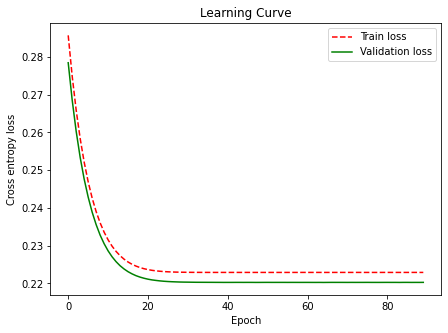


 Test AUC is 0.49786674976348877
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     

33748

In [ ]:
seed_value= 100 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

# Test without BN before alpha updater
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=2)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
train_dataloader, val_dataloader, test_dataloader  = loader(1)
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  if i == 1:
    break
i=model.GNN1(mol_dgl_graph.to(device), globalss.to(device))
i[2]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.2170, 0.2170, 0.2170, 0.2170, 0.2169, 0.2170, 0.2176, 0.2174, 0.2174,
         0.2176, 0.2170, 0.2169, 0.2170, 0.2170, 0.2170, 0.2170, 0.2174, 0.2176,
         0.2170, 0.2169, 0.2170, 0.2170, 0.2170, 0.2170],
        [0.2353, 0.2335, 0.2335, 0.2353, 0.2428, 0.2426, 0.2549, 0.2527, 0.2527,
         0.2549, 0.2426, 0.2428, 0.2335, 0.2353, 0.2335, 0.2353, 0.2527, 0.2549,
         0.2426, 0.2428, 0.2335, 0.2353, 0.2335, 0.2353],
        [0.6026, 0.5529, 0.5529, 0.6026, 0.8776, 0.8700, 0.9724, 0.9661, 0.9661,
         0.9724, 0.8700, 0.8776, 0.5529, 0.6026, 0.5529, 0.6026, 0.9661, 0.9724,
         0.8700, 0.8776, 0.5529, 0.6026, 0.5529, 0.6026]], device='cuda:0',
       grad_fn=<CatBackward>)

In [ ]:
mean = torch.empty(0, device=device)
train_dataloader, val_dataloader, test_dataloader  = loader(1000)
for i, (smiles, mol_dgl_graph, globalss, labels, masks) in enumerate(train_dataloader):
  out = model.GNN1(mol_dgl_graph.to(device), globalss.to(device))  
  mean = torch.cat((mean, out[0].view(-1,30)),0)
print(mean.shape)
mean = torch.mean(mean, 0)
print(mean.shape)
mean

torch.Size([6249, 30])
torch.Size([30])


tensor([ 1.3575e+03, -3.2892e+01,  4.9874e+05,  7.6939e+05,  6.9726e+05,
        -3.2917e+01,  5.5646e+05,  8.6640e+03, -3.2917e+01,  6.9822e+05,
         1.0778e+06, -3.2917e+01,  9.1213e+05,  1.5732e+03,  4.7437e+05,
         6.5261e+05, -3.2917e+01,  5.5970e+05,  5.6804e+05,  5.3288e+05,
         6.3872e+05,  1.0015e+04, -3.2917e+01, -3.2917e+01,  1.2162e+06,
        -3.2917e+01,  1.1052e+05, -3.2917e+01,  3.8147e+05, -3.2917e+01],
       device='cuda:0', grad_fn=<MeanBackward1>)

[ 54/200] train_loss: 0.17340 valid_loss: 0.21544
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 857.1443684101105 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

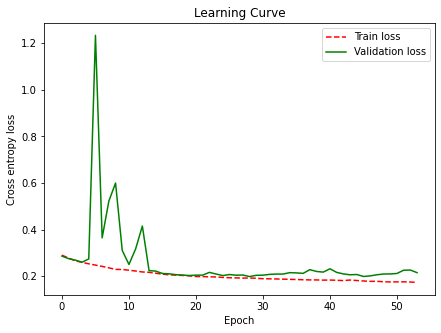


 Test AUC is 0.7286671002705892
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33748

In [ ]:
# Test with a good initial state and without BN before alpha updater

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=3)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15, affine=False)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 76/200] train_loss: 0.13663 valid_loss: 0.17954
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1093.4514906406403 seconds in cpu




<Figure size 504x360 with 0 Axes>

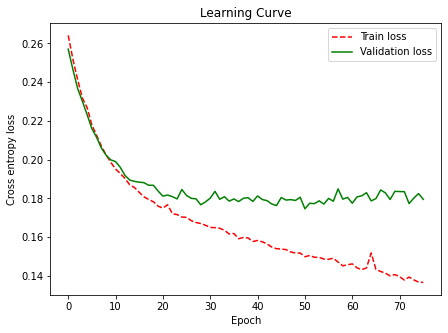


 Test AUC is 0.7952938079833984
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33748

In [ ]:
# Test without BN before alpha updater
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=2)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 90/200] train_loss: 0.17919 valid_loss: 0.19406
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 2138.197608232498 seconds in cuda:0




<Figure size 504x360 with 0 Axes>

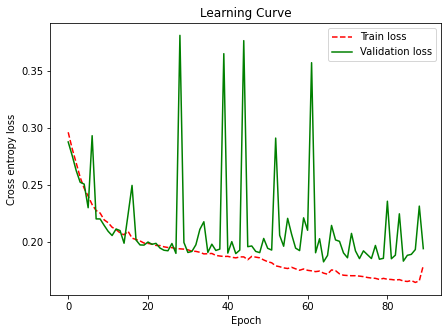


 Test AUC is 0.7752970854441324
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33748

In [ ]:
# Test with a good initial state and without BN before alpha updater

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=5)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.bn = nn.BatchNorm1d(15, affine=False)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
    model.eval()
    train_dataloader, val_dataloader, test_dataloader  = loader(1000)
    metric = roc_auc_score
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)



 Test AUC is 0.7752970854441324


In [ ]:
# Test without BN before alpha updater
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30, num_layers=5)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=20, n_epochs=200)
count_parameters(model)

[ 60/200] train_loss: 0.15401 valid_loss: 0.20192
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 887.3742315769196 seconds in cpu




<Figure size 504x360 with 0 Axes>

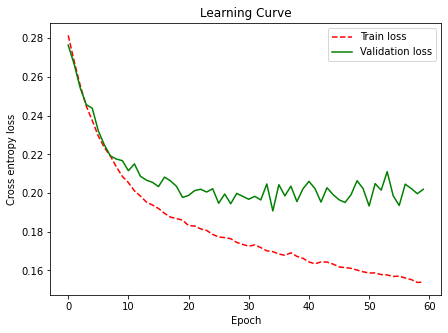


 Test AUC is 0.7474063237508138
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    870     |
|    GNN1.linear_0_v.bias    |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|   GNN1.linear_m_0.weight   |    1800    |
|   GNN1.linear_m_1.weight   |    900     |
|   GNN1.linear_v_0.weight   |    2700    |
|    GNN1.linear_v_0.bias    |     30     |
|   GNN1.linear_v_1.weight   |    900     |
|    GNN1.linear_v_1.bias    |     30     |
|   GNN1.linear_r_0.weight   |    2700    |
|    GNN1.linear_r_0.bias    |     30     |
|   GNN1.linear_r_1.weight   |    900     |

33748

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=2)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
    metric = roc_auc_score
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)



 Test AUC is 0.728668212890625


In [ ]:
ls

sample_data/


In [ ]:
>>> # With Learnable Parameters
>>> m1 = nn.BatchNorm1d(2)
>>> # Without Learnable Parameters
>>> m2 = nn.BatchNorm1d(2, affine=False)
>>> input = 100*torch.randn(50, 2)
>>> output = m2(input)
input, output

(tensor([[  68.8421, -111.5514],
         [ -38.1391,   79.8285],
         [  82.4185,  237.3892],
         [  55.6399,  -99.5923],
         [-200.2856,   37.8318],
         [-128.8514,  153.7194],
         [  18.8411,   12.2055],
         [ -11.9588, -190.8757],
         [-146.3088,   -9.6151],
         [-111.5356,  -33.1359],
         [ -16.0692,  -66.2575],
         [-109.5591,  -65.8367],
         [ 222.7342,    2.6988],
         [  96.8187,   66.0808],
         [ -31.1790, -236.9653],
         [ 139.7986,    5.3781],
         [  53.3613,   11.9775],
         [ -22.2658, -121.7942],
         [-100.6796,   23.3015],
         [  57.9128,  155.7978],
         [  48.2635,    4.8502],
         [  54.7197, -158.1169],
         [  69.7944,  227.0485],
         [   2.2320,   -4.7171],
         [ 114.0674,   31.5817],
         [ -43.9052,   26.0957],
         [  11.8256,   49.5903],
         [  98.6113,  103.6091],
         [  87.0475,  -55.6893],
         [   2.3992,   27.5002],
         [